## **Paper Information**

**Master: Meta Style Transformer for Controllable Zero-Shot and Few-Shot Artistic Style Transfer, CVPR 2023**, Hao Tang, Songhua Liu, Tianwei Lin, Shaoli Huang, Fu Li, Dongliang He, Xinchao Wang

*   Paper Link: https://openaccess.thecvf.com/content/CVPR2023/papers/Tang_Master_Meta_Style_Transformer_for_Controllable_Zero-Shot_and_Few-Shot_Artistic_CVPR_2023_paper.pdf


**Project Group Members:**

*   Melih Gökay Yiğit, gokay.yigit@metu.edu.tr
*   Veli Umut Özyurt, umut.ozyurt@metu.edu.tr

## **Paper Summary**

### **Introduction**

Artistic style transfer, the process of applying the stylistic elements of one image to the content of another, has gained significant attention in recent years. Traditional methods often struggle with limitations such as over-parameterization and content distortion when employing Transformer-based models. While Transformers excel at capturing global context and complex dependencies, their multi-layer structures result in a heavy computational burden and increased difficulty in training. Furthermore, the standard use of residual connections in Transformers can lead to unwanted content distortion, undermining the integrity of the original content structure.

This paper introduces Master: Meta Style Transformer, a novel approach designed to address these challenges. By sharing parameters across different Transformer layers and implementing a learnable scaling mechanism, the Master model reduces the overall number of parameters, improves training convergence, and enhances the quality of stylization. Additionally, a meta-learning framework allows for efficient adaptation to new styles, making the model versatile for both zero-shot and few-shot style transfer scenarios. The innovative design not only alleviates the computational burden but also achieves superior results in maintaining content fidelity and stylization quality, thereby pushing the boundaries of what’s achievable in artistic style transfer.

### **Model Architecture and Training**

The proposed Meta Style Transformer (Master) model comprises three main components: an encoder, a feature modification module, and a decoder (Figure 1). The encoder leverages the first two stages of the Swin Transformer to extract features from both content and style images. The feature modification module, named Style Transformer, alternates between Transformer encoder and decoder layers with shared parameters across all layers, enabling efficient training and reducing the overall parameter count. The decoder reconstructs the stylized image from the modified features.

<div style="text-align: center;">
    <figure>
        <img src="./src/model.png" alt="Model Architecture Overview" style="width:1200px; height:auto;">
        <figcaption> <b> Figure 1.</b> Model Architecture Overview.</figcaption>
    </figure>
</div>

During the training phase, the model employs a two-stage process: meta training and fast adaptation. The meta training stage, inspired by the Reptile algorithm [(Nichol et al., 2018)](https://arxiv.org/abs/1803.02999), seeks an optimal initialization that allows the model to quickly adapt to new styles with minimal updates. This stage involves sampling styles and performing inner optimizations to guide the updates of the model parameters. The fast adaptation stage fine-tunes the model for specific styles, focusing on updating only the Transformer encoder layers, which significantly speeds up the adaptation process.


#### Encoder Architecture

The encoder in the Master model uses the first two stages of the Swin Transformer [(Liu et al., 2021)](https://arxiv.org/abs/2103.14030) (Figure 2.), which is designed to efficiently capture image features through hierarchical and shifted window attention mechanisms. This architecture divides the input content and style images into 4x4 patches, allowing the encoder to extract multi-scale features that are essential for detailed and coherent style transfer. The Swin Transformer’s hierarchical structure and local attention ensure that both global and local information are effectively captured, providing a robust foundation for subsequent feature modification and decoding. This efficient and powerful encoding process is crucial for achieving high-quality style transfer with reduced computational complexity.

<div style="text-align: center;">
    <figure>
        <img src="./src/swin.png" alt="Swin Transformer Architecture Overview" style="width:1200px; height:auto;">
        <figcaption> <b> Figure 2.</b> Swin Transformer Architecture Overview.</figcaption>
    </figure>
</div>

#### StyleTransformer Architecture

The Style Transformer is the core component responsible for content-style interaction and modification within the Master model. This architecture alternates between Transformer encoder and decoder layers, with parameters shared across all layers to reduce computational overhead and facilitate efficient training. A feature of this model is the use of shifted window attention [(Liu et al., 2021)](https://arxiv.org/abs/2103.14030) in the all multi-head attention (MHA) blocks, which enhances the efficiency and scalability of the model by focusing attention within local windows that shift across layers.

A crucial aspect of the Style Transformer is the replacement of traditional residual connections with learnable scaling and shifting parameters. The use of learnable scaling and shifting parameters addresses the problem of content distortion commonly seen in traditional residual connections. By dynamically adjusting the content features based on these parameters, the model preserves the original content structure more effectively. This method allows the model to achieve a balanced integration of style and content, resulting in stylized images that retain the essential characteristics of the original content while adopting the desired artistic style.

##### Transformer Encoder Layer

The Transformer encoder layer processes features related to the style and generates three key outputs: style parameters $K_s$, scaling parameters $V_σ$, and shifting parameters $V_μ$. The style features are first processed using self-attention, which captures dependencies within the style image itself. The prediction of each part shares a same self-attention map to save memory but uses independent non-linear transformation. The process in the Transformer encoder layer can be formulated as:


$$
MHA(Q, K, V) = [head_1, ..., head_h]W^O
$$

$$
head_i = Att(QW^{Q_i}, KW^{K_i}, VW^{V_i})
$$

$$
Att(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

$$
K'_s = K_s + MHA(K_s, K_s, K_s)
$$

$$
K_s = K'_s + MLP(K'_s)
$$

$$
V'_σ = V_σ + MHA(K_s, K_s, V_σ)
$$

$$
V_σ = V'_σ + MLP(V'_σ)
$$

$$
V'_μ = V_μ + MHA(K_s, K_s, V_μ)
$$

$$
V_μ = V'_μ + MLP(V'_μ)
$$


Following self-attention, the style features are passed through a multi-layer perceptron (MLP) block for non-linear transformation. This process generates the keys needed for cross-attention in the decoder layer, as well as the learnable scaling and shifting parameters. These parameters are crucial for preserving the integrity of the content structure while effectively blending in the style features. Also, authors don't incorporated normalization to encode style features since second-order statistics can largely represent style information.

##### Transformer Decoder Layer

In the Transformer decoder layer, the encoded content features undergo a series of transformations to integrate style information. Initially, the content features are processed using self-attention to model internal dependencies. The cross-attention step follows, where scaling and shifting parameters for each content feature point is aggregated from $V_σ$ and $V_μ$ respectively according to the cross-attention map of content features (queries) and style features generated by the encoder (keys). The process in one Transformer decoder block can be written as:


$$
F'_{cs} = F_{cs} + MHA(F_{cs}, F_{cs}, F_{cs})
$$

$$
\sigma = MHA(IN(F'_{cs}), IN(K_{s}), V_{\sigma})
$$

$$
\mu = MHA(IN(F'_{cs}), IN(K_{s}), V_{\mu})
$$

$$
F''_{cs} = \sigma \odot F'_{cs} + \mu
$$

$$
F_{cs} = F''_{cs} + MLP(F''_{cs})
$$


Instead of using traditional residual connections, which can distort the original content structure, the Style Transformer employs dynamic and learnable scaling and shifting operations. These operations adjust the content features based on the scaling and shifting parameters derived from the style encoder. This approach helps to maintain the original spatial relationships and similarities within the content image while incorporating vivid style patterns, ensuring high-quality and coherent style transfer.


#### Decoder Architecture

The final step in the Master model is the decoder, which synthesizes the stylized image from the modified content features. The decoder follows a standard architecture [(Huang & Belongie, 2017)](https://arxiv.org/abs/1703.06868) with multiple upsampling convolutional blocks that progressively reconstruct the high-resolution image from the transformed features.

### Training Pipeline

The training process of the MASTER model involves two key stages: meta training (Algorithm 1.) and fast adaptation. This dual-stage approach enables the model to learn a robust initial state that can be quickly adapted to new styles with minimal updates.


<div style="text-align: center;">
    <figure>
        <img src="./src/meta.png" alt="Meta Training Algorithm" style="width:600px; height:600px;">
        <figcaption> <b> Algorithm 1.</b> Meta Training Algorithm.</figcaption>
    </figure>
</div>


#### Meta Training

Inspired by the Reptile algorithm [(Nichol et al., 2018)](https://arxiv.org/abs/1803.02999), the meta training stage aims to find an optimal initialization for the neural network, allowing it to adapt rapidly to new style transfer tasks. During this stage, the model undergoes a series of inner and outer loop updates:

1. **Inner Loop**: For each iteration, a style image is sampled, and the current model parameters are used to perform a series of updates on a batch of content images. The number of Transformer layers used in each iteration is randomly sampled, which helps the model learn to generalize across different configurations. The loss computed in this step guides the updates to obtain "fast weights."

2. **Outer Loop**: The "fast weights" obtained from the inner loop are used to adjust the model's "slow weights" or meta parameters. This step ensures that the model gradually learns an initialization that performs well across various styles and configurations.

By training in this manner, the model learns a versatile initialization that can be fine-tuned quickly and efficiently for specific styles, significantly reducing the overall training time required for each new style.

#### Fast Adaptation

Once the meta training stage is complete, the model is fine-tuned for specific styles through fast adaptation. This stage is crucial for few-shot style transfer scenarios, where the model must adapt to a new style with only a few examples. The fast adaptation process is similar to the inner loop of the meta training stage but focuses on fine-tuning the parameters of the Transformer encoder layer:

1. **Initialization**: The model starts with the parameters learned during the meta training stage.
2. **Few-Shot Updates**: For the new style, the model performs a limited number of updates using a small set of style images. Only the parameters of the Transformer encoder layer are updated during this stage, which significantly reduces the memory and computational requirements.

This targeted fine-tuning allows the model to quickly adapt to new styles, achieving high-quality stylization with minimal training data and computational effort. The fast adaptation stage ensures that the Master model can handle both zero-shot and few-shot style transfer scenarios effectively, providing a flexible and powerful solution for artistic style transfer tasks.

### Loss Functions

The training of the Master model utilizes a combination of content and style loss functions to ensure high-quality stylization while preserving the structure of the content image. 

#### Content Loss

The content loss aims to maintain the semantic structure and details of the original content image in the stylized output. This is achieved using a normalized perceptual loss, which compares the features of the content and stylized images extracted from a pre-trained VGG19 network. The content loss is defined as:

$$
L_{\text{cont}} = \sum_{x=2}^5 \| \text{IN}(F^x_c) - \text{IN}(F^x_{cs}) \|^2 
$$

where $F^x$ represents the features from layer $x$ of the VGG19 network [(Simonyan & Zisserman, 2017)](https://arxiv.org/abs/1409.1556), and $\text{IN}$ denotes instance normalization. This loss ensures that the stylized image retains the structural integrity of the original content image.

#### Style Loss

The style loss measures the degree to which the stylized image matches the style of the reference style image. This is achieved using the mean-variance loss, which compares the channel-wise mean and standard deviation of the features from the style and stylized images. The style loss is defined as:


$$
L_{\text{sty}} = \sum_{x=2}^5 \left( \| \mu(F^x_s) - \mu(F^x_{cs}) \|^2 + \| \sigma(F^x_s) - \sigma(F^x_{cs}) \|^2 \right)
$$


where $\mu$ and $\sigma$ denote the channel-wise mean and standard deviation, respectively. This loss ensures that the stylized image captures the texture and color patterns of the style image.

#### Combined Loss

The overall objective during training is to balance the content and style losses. The combined loss function is given by:

$$
L = L_{\text{cont}} + \lambda L_{\text{sty}}
$$

where $\lambda$ is a hyper-parameter that controls the balance between content preservation and style rendering. By adjusting $\lambda$, the model can be fine-tuned to emphasize either content fidelity or stylization quality.



## **Experimental Goals**

Our focus is on reproducing the quantitative results specified in Table 1, row "Ours-ZS-L1," to evaluate the model's performance under zero-shot conditions with 1 layer settings. Additionally, we plan to replicate the qualitative outcomes presented in Figure 3., following the same zero-shot setting, to visually assess the effectiveness of our implementation.

<div style="text-align: center;">
    <figure>
        <img src="./src/quant-table.png" alt="Quantitative comparisons" style="width:600px; height:600px;">
        <figcaption> <b> Table 1.</b> Quantitative comparisons. ZS and FS for "ours" denote zero-shot and few-shot modes.</figcaption>
    </figure>
</div>
<div style="text-align: center;">
    <figure>
        <img src="./src/master-out.png" alt="ex outputs" style="width:600px; height:600px;">
        <figcaption> <b> Figure 3.</b> Example outputs of the Master model.</figcaption>
    </figure>
</div>

# Importing Libraries

In [2]:
import os
import glob
import cv2
import numpy as np
import argparse
import sys
import matplotlib.pyplot as plt

project_root_path = os.getcwd()

sys.path.append(project_root_path)

import torch
import torch.nn as nn
from torchvision import transforms


from train_only_inner_loop import Train
from test_model import Test


from codes.full_model import MasterStyleTransferModel
from codes.loss import custom_loss

# Hyperparameters

In [3]:
# set the parser
parser = argparse.ArgumentParser(description= 'Master: Meta Style Transformer for Controllable Zero-Shot and Few-Shot Artistic Style Transfer Implementation')
args = parser.parse_args(args=[])

In [4]:
args.project_root =  os.getcwd()

args.model_save_path = "exps/models"

args.coco_dataset_path = "datasets/coco_train_dataset/train2017"

args.wikiart_dataset_path = "datasets/wikiart/**"

args.loss_model_path = "weights/vgg_19_last_layer_is_relu_5_1_output.pt"

args.use_vgg19_with_batchnorm = False

args.batch_size_style = 1

args.batch_size_content = 4

args.num_workers = 4

args.shuffle = True

args.use_infinite_sampler = True

args.pin_memory = True

args.freeze_encoder = True

args.inner_lr = 0.0001

args.outer_lr = 0.0001

args.num_inner_updates = 1

args.max_layers = 4

args.lambda_style = 10.0

args.loss_distance_content = 'euclidian'

args.loss_distance_style = 'euclidian'

args.use_random_crop = True

args.use_imagenet_normalization_for_swin = True

args.use_imagenet_normalization_for_loss = True

args.save_every = 100

args.save_every_for_model = 1000

args.max_iterations = 15000

args.swin_model_relative_path = "weights/swin_B_first_2_stages.pt"

args.swin_variant = "swin_B"

args.style_encoder_dim = 256

args.style_decoder_dim = 256

args.style_encoder_num_heads = 8

args.style_decoder_num_heads = 8

args.style_encoder_window_size = [7, 7]

args.style_decoder_window_size = [7, 7]

args.style_encoder_shift_size = [4, 4]

args.style_decoder_shift_size = [4, 4]

args.style_encoder_mlp_ratio = 4.0

args.style_decoder_mlp_ratio = 4.0

args.style_encoder_dropout = 0.0

args.style_decoder_dropout = 0.0

args.style_encoder_attention_dropout = 0.0

args.style_decoder_attention_dropout = 0.0

args.style_encoder_qkv_bias = True

args.style_decoder_qkv_bias = True

args.style_encoder_proj_bias = True

args.style_decoder_proj_bias = True

args.style_encoder_stochastic_depth_prob = 0.1

args.style_decoder_stochastic_depth_prob = 0.1

args.style_encoder_norm_layer = None

args.style_decoder_norm_layer = nn.LayerNorm

args.style_encoder_MLP_activation_layer = nn.GELU

args.style_decoder_MLP_activation_layer = nn.GELU

args.style_encoder_if_use_processed_Key_in_Scale_and_Shift_calculation = True

args.style_decoder_use_instance_norm_with_affine = False

args.style_decoder_use_regular_MHA_instead_of_Swin_at_the_end = False

args.style_decoder_use_Key_instance_norm_after_linear_transformation = True

args.style_decoder_exclude_MLP_after_Fcs_self_MHA = False

args.decoder_initializer = "kaiming_normal_"

args.style_transformer_load_pretrained_weights = False

args.style_transformer_pretrained_weights_path = "weights/model_basic_layer_1_module_list_shifted_window_block_state_dict.pth"

args.use_wandb = False

args.online = True

args.exp_name = 'master'

args.set_seed = False

args.seed = 42

args.verbose = True


### Change from original hyperparameters:

In [5]:
# We changed some of the default values, which is decided by our experiments. We have failed with over 100 different trials.
# To demonstrate the our best results (where content is somehow preserved), you can use the following parameters.


# If you want to use the default parameters (in our interpretation), do not run this cell.

args.set_seed = True # Set the seed for reproducibility

args.seed = 42 # Set the seed to 42

args.use_wandb = False # Use wandb for logging

args.batch_size_content = 2 # THIS IS DUE TO GPU MEMORY LIMITATIONS. IF IT CAN BE INCREASED, IT IS BETTER TO USE 4.

args.max_iterations = 200000 # Increase the number of iterations

args.save_every = 100 # Save the output images every 100 iterations with wandb

args.save_every_for_model = 100 # Save the model every 100 iterations


# loss choices aligned better with the loss values for the screenshots obtained from the paper (screenshots are used as content, style and output to pick them)
args.loss_distance_content="euclidian_squared" # Use euclidian squared distance for content loss

args.loss_distance_style="euclidian_squared" # Use euclidian distance for style loss (default)

args.use_imagenet_normalization_for_loss=False # Do not use imagenet normalization for loss

args.use_imagenet_normalization_for_swin=False # Do not use imagenet normalization for swin


args.pretrained_style_transformer_path = ""
args.pretrained_decoder_path = ""

args.fast_adaptation_stage_on = False # Do not use fast adaptation stage

args.decoder_initializer = "default" # Use pytorch's default initializer for decoder

args.lambda_style = 1.5 # Decrease the weight of style loss (in our experiments, whenever we use high style lambda coefficient, content was quickly lost)

args.exp_name = "experiment_66" # Name of our experiment

# If you want to use the default parameters, do not run this cell.

# Setting Device

In [6]:
# Set the device
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(args.device)

cuda:0


# Train

In [7]:
# For demonstration purposes, we will run low amount of iterations
args.max_iterations = 20

# Create the trainer
trainer = Train(config=args)

# Start the training
trainer.train()

Using seed 42

Initializing the weights of the style transformer with truncated normal initialization!

MasterStyleTransferModel
  - swin_encoder.0.0.weight: torch.Size([128, 3, 4, 4])
  - swin_encoder.0.0.bias: torch.Size([128])
  - swin_encoder.0.2.weight: torch.Size([128])
  - swin_encoder.0.2.bias: torch.Size([128])
  - swin_encoder.1.0.norm1.weight: torch.Size([128])
  - swin_encoder.1.0.norm1.bias: torch.Size([128])
  - swin_encoder.1.0.attn.relative_position_bias_table: torch.Size([169, 4])
  - swin_encoder.1.0.attn.qkv.weight: torch.Size([384, 128])
  - swin_encoder.1.0.attn.qkv.bias: torch.Size([384])
  - swin_encoder.1.0.attn.proj.weight: torch.Size([128, 128])
  - swin_encoder.1.0.attn.proj.bias: torch.Size([128])
  - swin_encoder.1.0.norm2.weight: torch.Size([128])
  - swin_encoder.1.0.norm2.bias: torch.Size([128])
  - swin_encoder.1.0.mlp.0.weight: torch.Size([512, 128])
  - swin_encoder.1.0.mlp.0.bias: torch.Size([512])
  - swin_encoder.1.0.mlp.3.weight: torch.Size([128, 

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration:          1/20


  5%|▌         | 1/20 [00:02<00:41,  2.20s/it]

Total Loss: 12.77, Content Loss: 6.22, Style Loss: 4.36, Num Layers: 1



Iteration:          2/20


 10%|█         | 2/20 [00:02<00:18,  1.00s/it]

Total Loss: 24.46, Content Loss: 6.52, Style Loss: 11.96, Num Layers: 1



Iteration:          3/20
Total Loss: 18.48, Content Loss: 6.30, Style Loss: 8.12, Num Layers: 3


 15%|█▌        | 3/20 [00:02<00:11,  1.52it/s]




Iteration:          4/20
Total Loss: 10.56, Content Loss: 6.19, Style Loss: 2.91, Num Layers: 2


 20%|██        | 4/20 [00:02<00:07,  2.08it/s]




Iteration:          5/20
Total Loss: 23.03, Content Loss: 6.60, Style Loss: 10.95, Num Layers: 2


 25%|██▌       | 5/20 [00:03<00:05,  2.61it/s]




Iteration:          6/20
Total Loss: 14.06, Content Loss: 6.53, Style Loss: 5.02, Num Layers: 2


 35%|███▌      | 7/20 [00:03<00:03,  3.64it/s]




Iteration:          7/20
Total Loss: 13.78, Content Loss: 6.13, Style Loss: 5.10, Num Layers: 1



Iteration:          8/20


 40%|████      | 8/20 [00:03<00:02,  4.12it/s]

Total Loss: 16.85, Content Loss: 6.36, Style Loss: 6.99, Num Layers: 1



Iteration:          9/20


 45%|████▌     | 9/20 [00:03<00:02,  3.92it/s]

Total Loss: 15.22, Content Loss: 6.43, Style Loss: 5.86, Num Layers: 4



Iteration:         10/20


 50%|█████     | 10/20 [00:04<00:02,  4.34it/s]

Total Loss: 17.66, Content Loss: 6.33, Style Loss: 7.56, Num Layers: 1



Iteration:         11/20
Total Loss: 10.65, Content Loss: 6.34, Style Loss: 2.87, Num Layers: 1


 60%|██████    | 12/20 [00:04<00:01,  4.97it/s]




Iteration:         12/20
Total Loss: 17.78, Content Loss: 6.45, Style Loss: 7.55, Num Layers: 1



Iteration:         13/20


 65%|██████▌   | 13/20 [00:04<00:01,  4.90it/s]

Total Loss: 14.83, Content Loss: 6.19, Style Loss: 5.76, Num Layers: 2



Iteration:         14/20


 70%|███████   | 14/20 [00:04<00:01,  4.86it/s]

Total Loss: 9.27, Content Loss: 6.63, Style Loss: 1.76, Num Layers: 2



Iteration:         15/20
Total Loss: 16.78, Content Loss: 6.11, Style Loss: 7.11, Num Layers: 1


 75%|███████▌  | 15/20 [00:04<00:00,  5.10it/s]




Iteration:         16/20
Total Loss: 18.50, Content Loss: 6.44, Style Loss: 8.04, Num Layers: 2


 80%|████████  | 16/20 [00:05<00:00,  4.99it/s]




Iteration:         17/20
Total Loss: 13.81, Content Loss: 6.72, Style Loss: 4.72, Num Layers: 4


 85%|████████▌ | 17/20 [00:05<00:00,  4.44it/s]




Iteration:         18/20
Total Loss: 7.95, Content Loss: 6.58, Style Loss: 0.91, Num Layers: 2


 90%|█████████ | 18/20 [00:05<00:00,  4.53it/s]




Iteration:         19/20
Total Loss: 11.58, Content Loss: 6.82, Style Loss: 3.17, Num Layers: 4


 95%|█████████▌| 19/20 [00:05<00:00,  4.18it/s]




Iteration:         20/20
Total Loss: 8.65, Content Loss: 6.14, Style Loss: 1.67, Num Layers: 3


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]

# Loading Pre-trained Model

In [8]:
# pretrained model paths
full_model_path = "test/pretrained_weights/pretrained_model.pt"

# load the model
master_style_transfer_model = MasterStyleTransferModel(
    project_absolute_path = os.getcwd(),
    swin_model_relative_path = "weights/swin_B_first_2_stages.pt",
    swin_variant = "swin_B",
    style_encoder_dim = 256,
    style_decoder_dim = 256,
    style_encoder_num_heads = 8,
    style_decoder_num_heads = 8,
    style_encoder_window_size = [7, 7],
    style_decoder_window_size = [7, 7],
    style_encoder_shift_size = [4, 4],
    style_decoder_shift_size = [4, 4],
    style_encoder_mlp_ratio = 4.0,
    style_decoder_mlp_ratio = 4.0,
    style_encoder_dropout = 0.0,
    style_decoder_dropout = 0.0,
    style_encoder_attention_dropout = 0.0,
    style_decoder_attention_dropout = 0.0,
    style_encoder_qkv_bias = True,
    style_decoder_qkv_bias = True,
    style_encoder_proj_bias = True,
    style_decoder_proj_bias = True,
    style_encoder_stochastic_depth_prob = 0.1,
    style_decoder_stochastic_depth_prob = 0.1,
    style_encoder_norm_layer = None,
    style_decoder_norm_layer = torch.nn.LayerNorm,
    style_encoder_MLP_activation_layer = torch.nn.GELU,
    style_decoder_MLP_activation_layer = torch.nn.GELU,
    style_encoder_if_use_processed_Key_in_Scale_and_Shift_calculation = True,
    style_decoder_use_instance_norm_with_affine = False,
    style_decoder_use_regular_MHA_instead_of_Swin_at_the_end = False,
    style_decoder_use_Key_instance_norm_after_linear_transformation = True,
    style_decoder_exclude_MLP_after_Fcs_self_MHA = False,
    style_transformer_load_pretrained_weights = False,
)

# load the model
master_style_transfer_model.load_state_dict(torch.load(full_model_path))

# set the model to evaluation mode
master_style_transfer_model.eval()

# print model parameter count
print(f"Model parameter count: {sum(p.numel() for p in master_style_transfer_model.parameters() if p.requires_grad)}")

Model parameter count: 6418259


## Run the model on test set

In [9]:
### set the necessary things for the test

# define the flags
CALCULATE_STYLE_CONTENT_LOSS = True
CALCULATE_SIMILARITY_LOSS = False

SAVE_OUTPUTS = True

# test folder paths
content_images_path = "test/content_input"
style_images_path = "test/style_input"


output_path = "test/output_images"

if not os.path.exists(output_path):
    os.makedirs(output_path)


test_transform = transforms.Compose([
    transforms.ToPILImage(), # -> PIL image
    transforms.Resize((256, 256)), # -> resize to 512x512
    transforms.ToTensor()
])


# set the device
test_device = "cuda" if torch.cuda.is_available() else "cpu"

# load the model to the device
master_style_transfer_model = master_style_transfer_model.to(test_device)


# get the content image list
content_image_list = glob.glob(os.path.join(content_images_path, "*"))

# get the style image list
style_image_list = glob.glob(os.path.join(style_images_path, "*"))

## Calculate and display random results

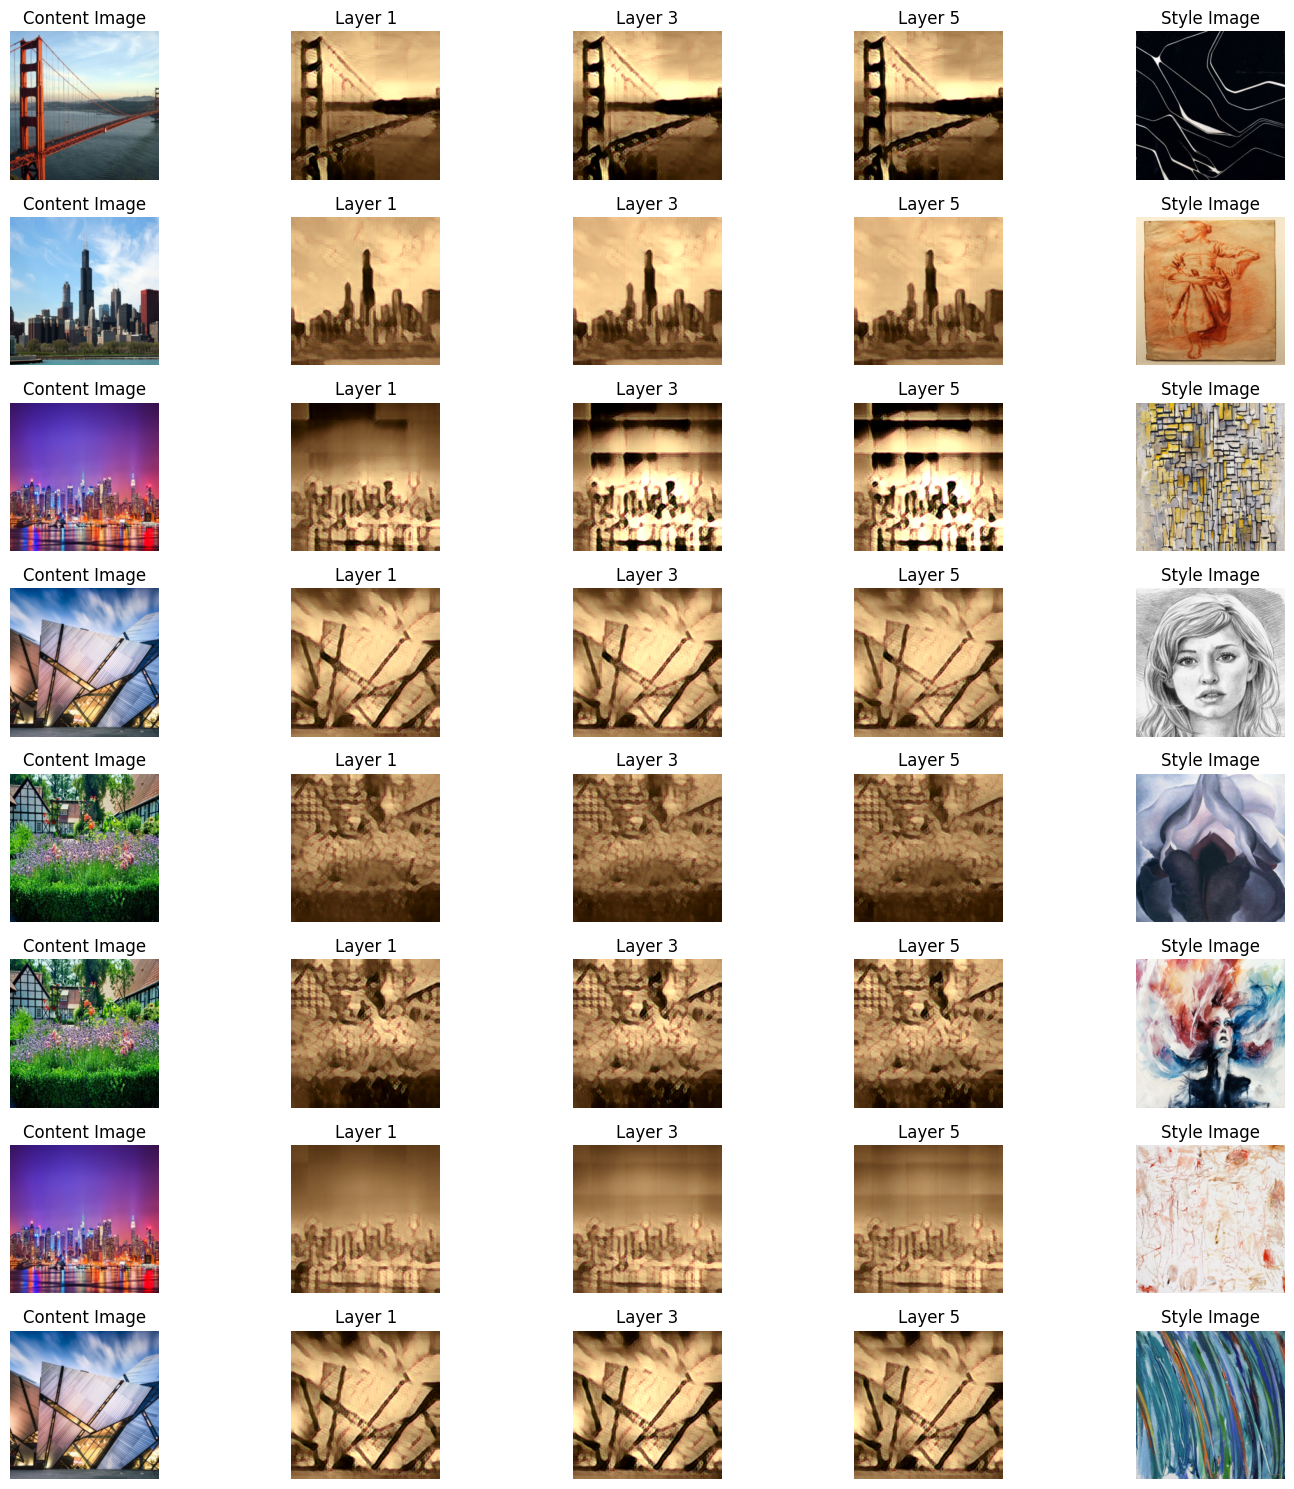

In [10]:
# pick a random image num
random_image_num = 8

# select random content and style images
random_content_paths = np.random.choice(content_image_list, random_image_num)
random_style_paths = np.random.choice(style_image_list, random_image_num)

# create a random_image_num x 3 grid (content, output_layer1, output_layer3, output_layer5, style)
fig, axes = plt.subplots(random_image_num, 5, figsize=(15, 15))

for i in range(random_image_num):
    # load the content image
    content_image = test_transform(cv2.cvtColor(cv2.imread(random_content_paths[i]), cv2.COLOR_BGR2RGB)).unsqueeze(0).to(test_device)

    # load the style image
    style_image = test_transform(cv2.cvtColor(cv2.imread(random_style_paths[i]), cv2.COLOR_BGR2RGB)).unsqueeze(0).to(test_device)

    # get the stylized image (with normalizations)
    with torch.no_grad():
        stylized_image_layer1 = master_style_transfer_model(content_image,
                                                            style_image,
                                                            transformer_layer_count=1)

        stylized_image_layer3 = master_style_transfer_model(content_image,
                                                            style_image,
                                                            transformer_layer_count=3)

        stylized_image_layer5 = master_style_transfer_model(content_image,
                                                            style_image,
                                                            transformer_layer_count=5)
    
    # display the images
    axes[i, 0].imshow(np.clip(content_image.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Content Image")

    axes[i, 1].imshow(np.clip(stylized_image_layer1.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Layer 1")

    axes[i, 2].imshow(np.clip(stylized_image_layer3.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 2].axis("off")
    axes[i, 2].set_title("Layer 3")

    axes[i, 3].imshow(np.clip(stylized_image_layer5.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 3].axis("off")
    axes[i, 3].set_title("Layer 5")

    axes[i, 4].imshow(np.clip(style_image.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1))
    axes[i, 4].axis("off")
    axes[i, 4].set_title("Style Image")

    

plt.tight_layout()
plt.show()

# Calculate the loss over the test set

In [11]:
if CALCULATE_STYLE_CONTENT_LOSS:
    # create the loss instance
    loss_instance = custom_loss(
        project_absolute_path=os.getcwd(),
        feature_extractor_model_relative_path="weights/vgg_19_last_layer_is_relu_5_1_output.pt",
        use_vgg19_with_batchnorm=False,
        default_lambda_value=10.0,
        distance_content="euclidian_squared",
        distance_style="euclidian_squared"
    )

    # set the loss instance to evaluation mode
    loss_instance.eval()

# load the loss instance to the device
loss_instance = loss_instance.to(test_device)



# open all images and preprocess them

processed_content_images = []
processed_style_images = []

for image_path in content_image_list:
    processed_content_images.append(test_transform(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)))

for image_path in style_image_list:
    processed_style_images.append(test_transform(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)))


if CALCULATE_STYLE_CONTENT_LOSS:
    # create a loss list
    total_loss_list = []
    content_loss_list = []
    style_loss_list = []

    if CALCULATE_SIMILARITY_LOSS:
        similarity_loss_list = []


# DETERMINE THE TRANSFORMER LAYER COUNT TO BE USED
transformer_layer_counts_to_try = [1, 3, 5]

for transformer_layer_count in transformer_layer_counts_to_try:
    print(f"FOR TRANSFORMER LAYER COUNT: {transformer_layer_count}")

    # iterate over all combinations of content and style images
    for content_image, content_image_path in zip(processed_content_images, content_image_list):

        # load the content image
        content_image = content_image.unsqueeze(0).to(test_device)

        # get the content image name wihtout the extension
        content_image_name = os.path.basename(content_image_path).split(".")[0]


        for style_image, style_image_path in zip(processed_style_images, style_image_list):

            # load the style image
            style_image = style_image.unsqueeze(0).to(test_device)

            # get the style image name wihtout the extension
            style_image_name = os.path.basename(style_image_path).split(".")[0]

            # get the output image name
            output_image_name = f"{content_image_name}_stylized_with_{style_image_name}_layers_{transformer_layer_count}.jpg"

            # get the output image path
            output_image_path = os.path.join(output_path, output_image_name)

            # get the stylized image
            with torch.no_grad():
                stylized_image = master_style_transfer_model(content_image,
                                                             style_image,
                                                             transformer_layer_count=transformer_layer_count)
            
                if CALCULATE_STYLE_CONTENT_LOSS:
                    # calculate the loss
                    loss = loss_instance(content_image,
                                         style_image,
                                         stylized_image,
                                         output_content_and_style_loss=True,
                                         output_similarity_loss=CALCULATE_SIMILARITY_LOSS)

                    if CALCULATE_SIMILARITY_LOSS:
                        total_loss, content_loss, style_loss, similarity_loss = loss

                        total_loss_list.append(total_loss.item())
                        content_loss_list.append(content_loss.item())
                        style_loss_list.append(style_loss.item())
                        similarity_loss_list.append(similarity_loss.item())
                    else:
                        total_loss, content_loss, style_loss = loss

                        total_loss_list.append(total_loss.item())
                        content_loss_list.append(content_loss.item())
                        style_loss_list.append(style_loss.item())

            

            if SAVE_OUTPUTS:
                # save the stylized image (conver from BGR to RGB and save it as uint8)
                cv2.imwrite(output_image_path, cv2.cvtColor(np.clip(stylized_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255, 0, 255).astype(np.uint8), cv2.COLOR_BGR2RGB))


    if CALCULATE_STYLE_CONTENT_LOSS:
        total_loss_mean = np.mean(total_loss_list)
        total_loss_std = np.std(total_loss_list)
        total_loss_confidence_interval = 1.96 * total_loss_std / np.sqrt(len(total_loss_list))

        content_loss_mean = np.mean(content_loss_list)
        content_loss_std = np.std(content_loss_list)
        content_loss_confidence_interval = 1.96 * content_loss_std / np.sqrt(len(content_loss_list))

        style_loss_mean = np.mean(style_loss_list)
        style_loss_std = np.std(style_loss_list)
        style_loss_confidence_interval = 1.96 * style_loss_std / np.sqrt(len(style_loss_list))

        print(f"Total Loss Mean:   {total_loss_mean:.2f},   Total Loss Std: {total_loss_std:.2f},   Confidence Interval: [{total_loss_mean - total_loss_confidence_interval:.2f}, {total_loss_mean + total_loss_confidence_interval:.2f}]")
        print(f"Content Loss Mean: {content_loss_mean:.2f}, Content Loss Std: {content_loss_std:.2f}, Confidence Interval: [{content_loss_mean - content_loss_confidence_interval:.2f}, {content_loss_mean + content_loss_confidence_interval:.2f}]")
        print(f"Style Loss Mean:   {style_loss_mean:.2f},   Style Loss Std: {style_loss_std:.2f},   Confidence Interval: [{style_loss_mean - style_loss_confidence_interval:.2f}, {style_loss_mean + style_loss_confidence_interval:.2f}]")

        if CALCULATE_SIMILARITY_LOSS:
            similarity_loss_mean = np.mean(similarity_loss_list)
            similarity_loss_std = np.std(similarity_loss_list)
            similarity_loss_confidence_interval = 1.96 * similarity_loss_std / np.sqrt(len(similarity_loss_list))

            print(f"Similarity Loss Mean: {similarity_loss_mean:.2f}, Similarity Loss Std: {similarity_loss_std:.2f}, Confidence Interval: [{similarity_loss_mean - similarity_loss_confidence_interval:.2f}, {similarity_loss_mean + similarity_loss_confidence_interval:.2f}]")

        print("\n")

FOR TRANSFORMER LAYER COUNT: 1
Total Loss Mean:   35.05,   Total Loss Std: 21.10,   Confidence Interval: [32.27, 37.84]
Content Loss Mean: 5.02, Content Loss Std: 0.63, Confidence Interval: [4.93, 5.10]
Style Loss Mean:   3.00,   Style Loss Std: 2.10,   Confidence Interval: [2.73, 3.28]


FOR TRANSFORMER LAYER COUNT: 3
Total Loss Mean:   33.60,   Total Loss Std: 19.64,   Confidence Interval: [31.76, 35.43]
Content Loss Mean: 5.07, Content Loss Std: 0.66, Confidence Interval: [5.01, 5.13]
Style Loss Mean:   2.85,   Style Loss Std: 1.95,   Confidence Interval: [2.67, 3.03]


FOR TRANSFORMER LAYER COUNT: 5
Total Loss Mean:   32.95,   Total Loss Std: 18.90,   Confidence Interval: [31.51, 34.40]
Content Loss Mean: 5.12, Content Loss Std: 0.67, Confidence Interval: [5.07, 5.18]
Style Loss Mean:   2.78,   Style Loss Std: 1.87,   Confidence Interval: [2.64, 2.93]




## **Challanges**

### 1. Discrepancies Between Descriptions and Visuals of the Style Transformer Model

The Style Transformer model, as depicted in the Figure 1., exhibited several inconsistencies when compared to its textual description. These discrepancies posed difficulties in understanding the exact architecture and implementation details required for effective model training and inference. The key discrepancies identified are as follows:

- **Inclusion of MLP Layer and Residual Connections**: The visual depiction of the model shows that following the self-attention mechanism in the Transformer Decoder block, an MLP layer and residual connections are included. However, the textual description fails to mention the presence of the MLP layer, leading to confusion regarding the actual components of the Transformer Decoder block.

- **Linear Projection Before Cross-Attention**: The image indicates that the content features do not undergo linear projection before the cross-attention mechanism in the Transformer Decoder block. This directly contradicts the textual description, which suggests that such a projection should occur. This inconsistency created ambiguity about the correct preprocessing steps required for the content features before cross-attention.

- **Instance Normalization Placement**: The visual representation shows that instance normalization is applied directly to the query and key projections used in the cross-attention mechanism. In contrast, the textual description specifies that instance normalization is applied before the projection, which affects the flow and normalization of the features. Additionally, the text does not clarify whether the instance normalization layers are affine or not, adding to the uncertainty.


### 2. Implementation of Parameter-Sharing Blocks in the Transformer Encoder Model

The Master model uses parameter-sharing across different Transformer layers to reduce computational overhead and enhance training efficiency. However, it lacks detailed guidelines on how to implement these parameter-sharing blocks, especially within the Transformer Encoder model. This ambiguity led to multiple interpretations and experimental approaches:

- **Value Projection Sharing for Scale and Shift**: One approach involved sharing the value projection in self-attention for both scaling and shifting parameters. This method aimed to leverage shared projections to simplify the model while maintaining effectiveness in capturing style information.

- **Distinct Projections with Shared Attention Maps**: Another approach used distinct projections for scaling and shifting parameters but utilized the same attention maps for both. This method sought to balance the trade-off between parameter sharing and the flexibility of having distinct projections for different tasks.


### 3. Model Size Mismatch

Another significant challenge encountered during the development of the Master model was the mismatch in model size. Depending on the choice of encoder model, specifically whether Swin-B or Swin-L was used, the number of parameters in our implementation either deviated significantly below or exceeded the stated number of parameters in the paper. This discrepancy suggests that there may be components of the model that are either not explained or not explained clearly in the paper.

- **Encoder Model Choice**: The choice of encoder, whether Swin-B (Swin Transformer Base) or Swin-L (Swin Transformer Large), significantly impacts the total number of parameters. Swin-B has fewer parameters compared to Swin-L, leading to substantial differences in the overall model size. When using Swin-B, our model's parameter count was considerably lower than the number stated in the paper. Conversely, with Swin-L, the parameter count was much higher.

- **Unexplained or Vaguely Explained Components**: The discrepancies in model size suggest that there may be additional components or specific configurations in the original model that are either not mentioned or not clearly described in the paper. For example:
  - **Hidden Dimensions**: The exact hidden dimensions of the model components, such as the MLPs, might vary based on the implementation, leading to differences in the total number of parameters.
  - **Normalization**: If additional normalization layers are present but not explicitly described, this could account for variations in parameter count.
  - **Auxiliary Modules**: The model might include auxiliary modules or additional layers that are not detailed in the paper but contribute to the total parameter count.
  - **Parameter-Sharing Mechanism**: The exact implementation of the parameter-sharing mechanism might differ, affecting the total number of parameters. If certain parameters are shared in a way not clearly outlined, this could lead to discrepancies.

To address the challenges we encountered with the model size, we followed the reviewers’ suggestions and conducted a thorough analysis of the effect of the MLP ratio in the Style Transformer module. This investigation aimed to evaluate how different MLP ratio settings impact the model’s performance.

<div style="text-align: center;">
    <img src="./src/master-mlpratio.png" alt="**Figure 4**: The outputs of the Master model with different mlp-ratios using meta training." width="1000" />
    <figcaption> <b> Figure 4.</b> The outputs of the Master model with different mlp-ratios using meta training.</figcaption>
</div>

### 4. Lack of Dataset and Hyper-Parameter Details for Zero-Shot Settings

One more critical challenge faced during the development of the model was the lack of explanations regarding the hyper-parameters and dataset specifics for the zero-shot settings. This gap in the paper's documentation made it difficult to replicate and validate the model's performance as described.

More specifically, the exact learning rate value, learning rate schedule, iteration count were tremendously important for the training, and since it should be different from the few-shot training settings, it was crucial to have these details. However, the paper did not provide any information on these hyper-parameters for the zero-shot setting.

During our attempts to replicate the zero-shot setting, we encountered significant difficulties in achieving decent results using the meta training algorithm (Algorithm 1., with k=1). Interestingly, when we switched to a non-meta training approach (i.e., using a single training loop without inner and outer loops), we obtained more promising results (Figure 4.). This suggests that there might be unmentioned or unclear modifications to the meta training algorithm for the zero-shot setting in the paper.

<div style="text-align: center;">
    <img src="./src/master-nometa-out1.png" alt="**Figure 4**: The outputs  of the  Master model without meta training." width="1000" />
</div>

<div style="text-align: center;">
    <img src="./src/master-nometa-out2.png" alt="**Figure 4**: The outputs of the  Master model without meta training." width="1000" />
    <figcaption> <b> Figure 4.</b> Example outputs of the Master model without meta training.</figcaption>
</div>

<div>

</div>

<div style="text-align: center;">
    <img src="./src/master-nometa-loss.png" alt="**Figure 5**: The loss plots of the  Master model without meta training." width="1000" />
    <figcaption> <b> Figure 5.</b> The loss plots of the  Master model without meta training.</figcaption>
</div>

### 5. The distance metric used in the loss function

The paper does not specifies whether the distance metric used in the loss function is Euclidean distance or Squared Euclidean distance. This limited our experiment opportunities since we had to try both distance metrics to find the most aligning one.

We also got the screenshots of the outputs of the model (from the paper's figure 4 and 9) and tried to input them in our loss function with trying both euclidian/squared euclidian distance metrics for both content and style features. Also, we tried to use the VGG19 in the loss funciton with/without batchnorm pre-trained version. Moreover, using imagenet statistics to normalize the inputs before feeding them to the VGG19 model was also tried, and we think that it may exist in the original implementation since considerable amount of computer vision projects normalize the inputs using the imagenet statistics.

Although these 16 different combinations of loss functions have been observed, we found that the VGG should not be used with batchnorm. Also, using squared euclidian for the content and euclidian for the style features gave the closest results reported in the paper when imagenet normalization is used. But since it is not plausible for them to be different without the authors' explanation, we are still not sure about the distance metrics used in the loss function.

Observing when euclidian squared distance is used for style loss, not using normalization resulted in **too high** style loss values:<br>

<div style="text-align: center;">
    <img src="./src/figure4_losses_column3_VGG_without_batchnorm_euclidian_squared_euclidian_squared_True.png" alt="**Figure 6**: Style distance is euclidian, imagenet normalization used." width="1000" />
    <figcaption> <b> Figure 6.</b> Style distance is euclidian squared, imagenet normalization used.</figcaption>
</div>


<div style="text-align: center;">
    <img src="./src/figure4_losses_column3_VGG_without_batchnorm_euclidian_squared_euclidian_squared_False.png" alt="**Figure 7**: Style distance is euclidian, imagenet normalization NOT used." width="1000" />
    <figcaption> <b> Figure 7.</b> Style distance is euclidian squared, imagenet normalization NOT used.</figcaption>
</div>

So, it is better to use euclidian squared for the stye loss when imagenet normalization will not be used. But when imagenet normalization will be used.

# Some of the tried experiments:

In the training experiments, we tried a feasible amount of the combinations that can be obtained from the options below:

- Trying to initialize the weights of the swin cross attention blocks from the original swin models customly picket layers, assigning the weight values one by one to adapt the new architecture or not using pre-trained blocks.
- Initializing the decoder weights with kaiming_he_uniform, kaiming_he_normal, default pytorch initialization.
- Learning rate value (lots of choices)
- Using learning rate schedule or not
- Using the distance metric as euclidian or squared euclidian for content
- Using the distance metric as euclidian or squared euclidian for style
- Using VGG19 with batchnorm or not
- Using imagenet statistics for normalization or not for VGG inputs
- Using imagenet statistics for normalization or not for Swin backbone inputs
- Using meta training or not (we also tried and failed on few-shot training settings)
- Using different MLP hidden dimension ratios (like 3, 4, 10)
- Using different encoder models (Swin-B, Swin-T)
- Using different lambda style coefficients (such as 1, 1.5, 2, 3, 10)
- Using MLP after the Decoders first swin MHA self-attention or not (since it is not clear in the paper)
- Using linear transformation for key after or before the instance norm
- Using projection on the Query matrix before cross attention or not
- Using linear normalization layers in the decoder or not


## **Conclusion**
We deeply investigated why we failed to obtain the desired outputs, and came up with the following conclusions:

- There may be an expressivity problem in the model, which may be caused by the layers' width (MLP ratio, backbone architecture etc.). It also explains the parameter count differences between the original implementation and our implementation.
- There may be unexplained additional components in the model, which may be crucial for the model's performance.
- The training process may have additional features such as data augmentation, learning rate schedules, etc.
- The hyperparameters in the zero-shot settings should make a significant difference in the training process

Since we experimented with different lambda style values, we observed that we can catch the content very well when lambda is set to low and we tried for long with a relatively high learning rate (we also captured the colors in the content images this way). But when the lambda style value is high (like 10 as stated in the paper), we lost the whole content expression and the model started to generate very similar stylish and not meaningful images nearly in all of our experiments. But, when we tried to overfit a single style image, we could expressed the style in terms of its color, still losing the content even when we tried with just 16 content images, which means we couldn't overfit to both content and the style at the same time.

This may be caused from an architectural difference which causes the model to quickly overfit to a trivial-like solution in terms of satisfying the style loss. The style loss dominated the content but without capturing the actual styles, tricking the loss function, which also prevent learning the content.

Also, using only the first 2 stages of the swin model may be not enough for the style transformer model to work with meaningful feature representations (other models typically use a full VGG19 model as a backbone).


<div style="text-align: center;">
    <img src="src/style_sanity_check.png" alt="**Figure 8**: Result of trying to overfit to a single style image as a sanity check." width="1000" />
    <figcaption> <b> Figure 8.</b> Result of trying to overfit to a single style image as a sanity check. (style image is on the left, stylized image is on the right)</figcaption>
</div>


<div style="text-align: center;">
    <img src="src/experiment.png" alt="**Figure 9**: One of the low lambda_style value training results with a learning schedule." width="1000" />
    <figcaption> <b> Figure 9.</b> One of the low lambda_style value training results with a learning schedule.</figcaption>
</div>


One can observe the mentioned unwanted style overfitting in a trivial-like way in the following image


<div style="text-align: center;">
    <img src="src/trivial_like_unwanted_style_overfitting.png" alt="**Figure 10**: Unwanted overfitting to style image with high lambda style value." width="1000" />
    <figcaption> <b> Figure 10.</b> Unwanted overfitting to style image with high lambda style value.</figcaption>
</div>

Notice that the style image is on the left, and the stylized image further alignes with the content of the style image. It somehow can learn the content of the style (in a very coarse way) to better overfit the style loss. 

## **Responses to Peer-review**

1. "In the 2nd item, 1st subitem, they state the text does not mention the MLP, but actually it is in the first paragraph of 4th page. It also explicitly shown in the equation 4."

    	While it is correct that the MLP is mentioned in the first paragraph of the fourth page, our concern is about the explicit mention and description of the MLP layer within the Transformer Decoder block, as this is where we identified a discrepancy between the text and the visual representation. The visual representation (Figure 1.) clearly shows the inclusion of the MLP layer and residual connections following the self-attention mechanism within the Transformer Decoder block. However, the textual description of the Transformer Decoder in the relevant sections does not explicitly detail the presence and role of the MLP layer within this part of the module.

<div>

2. "In the 2nd item 2nd subitem, they mentioned linear projection but, we could not find anything about it in the paper."

		The linear projection is depicted in the image (Figure 1.) within the Transformer Decoder block. It is represented by the symbol “L” in the visual diagram.

<div>

3.  "We have checked the hyperparameters in the notebookand the hyperparameters provided in the paper, Implementation Details section. The hyperparameters provided in the paper seems used correct in the notebook. But some hyperparameters in the notebook are not explicitly mentioned in the paper, which are input resolution, and mlp_ratio. Note that both are related with StyleTransformer, and the authors of the notebook  mentioned the training results seems correct without StyleTransformer. Thus, the selection of these hyperparameters might be 
problematic."

		The input resolution referred to in our implementation is the resolution of the output of the Encoder. This resolution determines the size of the feature maps that are fed into the StyleTransformer module. We conducted extensive experiments with various MLP ratio settings, ranging from 3 up to 10, to evaluate their impact on the overall training process. Our findings indicated that varying the MLP ratio did not significantly alter the overall training dynamics or the final performance of the model. These experiments and their results are detailed in the Challanges section.

<div>

4. "In the implementation details section of the paper, it is mentioned that they first resized image and take random crop ONLY in training. And WikiArt dataset is also used as test style set. But in the implementation (get_dataloader.py file wikiart_dataset class), they resize and crop no matter whether it is used for training or test. Apart from that, data loaders seem implemented correctly."

		In the provided implementation (specifically in the get_dataloader.py file, wikiart_dataset class), images are resized and cropped regardless of whether they are used for training or testing. This was done primarily for the ease of testing. Ensuring a consistent preprocessing pipeline simplifies the testing process and avoids potential discrepancies between training and testing phases. It is important to note that at test time, the algorithm should be capable of handling images at any resolution without performance degradation.

## **Citation**

```
@INPROCEEDINGS {10203725,
  author = {H. Tang and S. Liu and T. Lin and S. Huang and F. Li and D. He and X. Wang},
  booktitle = {2023 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
  title = {Master: Meta Style Transformer for Controllable Zero-Shot and Few-Shot Artistic Style Transfer},
  year = {2023},
  pages = {18329-18338},
  doi = {10.1109/CVPR52729.2023.01758},
  url = {https://doi.ieeecomputersociety.org/10.1109/CVPR52729.2023.01758},
  publisher = {IEEE Computer Society},
}
```